### Preprocesado: Recorte de huella

En este markdown exploramos el preprocesado, centrándonos en técnicas para obtener el ROI, es decir, la zona de la huella, y descartar el resto de la imagen. El objetivo es quedarnos únicamente con la parte útil antes de realizar la extracción de características, evitando que elementos externos o ruido afecten al rendimiento final.

#### Método 1: Método por filas y columnas

En esta técnica se analiza la imagen binarizada recorriéndola fila por fila y columna por columna. En cada una se calcula la suma de píxeles blancos, y cuando esta suma supera cierto valor se interpreta que en esa zona aparece la huella. 

Sin embargo, los resultados no fueron satisfactorios: al haber elementos alrededor de la imagen (como números, líneas o pequeñas marcas), estos generaban picos en las sumas que se confundían con la huella real. No conseguimos definir un umbral que separara de forma fiable la huella del resto de información, por lo que esta técnica resultó poco precisa para nuestro caso.

Este código fue sido generado por ChatGPT, donde hemos hecho pequeñas modificaciones para adaptarlo a nuestras necesidades.

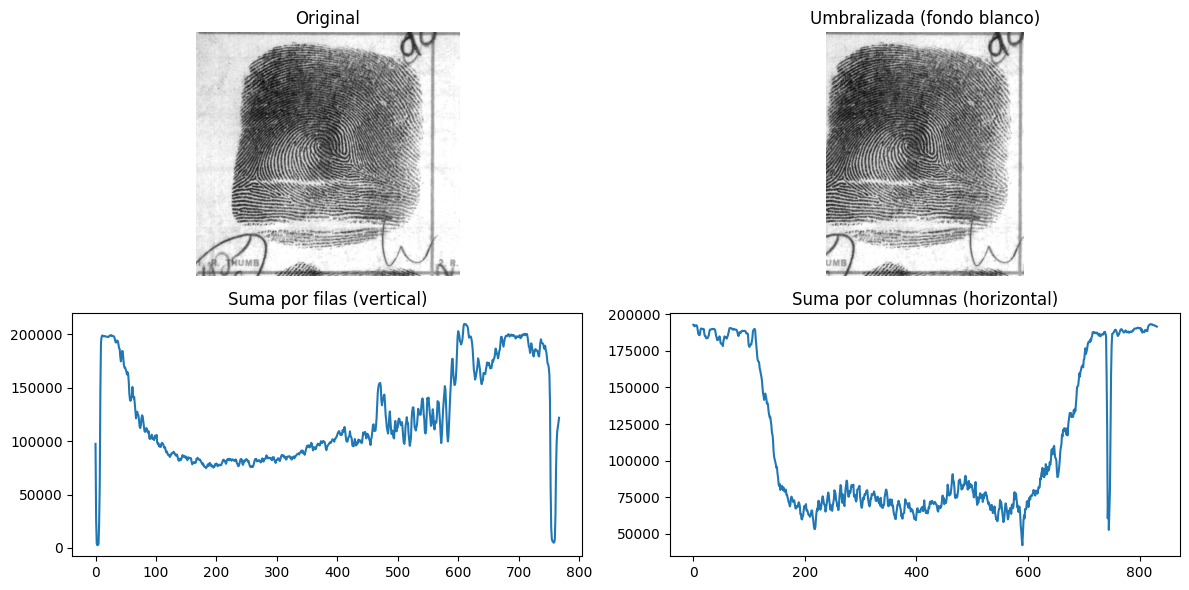

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def recorte_adaptativo(img):
    # Convertir a escala de grises
    if len(img.shape) == 3:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Umbralización (Otsu)
    _, thresh = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    # Asegurar fondo blanco (huella negra)
    white_ratio = np.sum(thresh == 255) / thresh.size
    black_ratio = np.sum(thresh == 0) / thresh.size
    if black_ratio > white_ratio:
        thresh = cv.bitwise_not(thresh)

    #  Sumar píxeles por filas y columnas 
    sum_rows = np.sum(thresh, axis=1)
    sum_cols = np.sum(thresh, axis=0)
    #print(sum_rows)
    # estas variables son unas listas de sumas de píxeles blancos por fila y columna respectivamente
    # cada posisción de la lista corresponde a una fila o columna de la imagen umbralizada
    # de esta forma podemos saber en qué filas y columnas hay más píxeles blancos (fondo) y en cuáles menos (huella)

    #  Umbral adaptativo 
    mean_row = np.mean(sum_rows[sum_rows < np.max(sum_rows)])
    mean_col = np.mean(sum_cols[sum_cols < np.max(sum_cols)])

    thr_row = 0.98 * mean_row
    thr_col = 0.98 * mean_col

    #  Filas/columnas donde hay huella 
    rows_nonwhite = np.where(sum_rows < thr_row)[0]
    cols_nonwhite = np.where(sum_cols < thr_col)[0]

    if len(rows_nonwhite) == 0 or len(cols_nonwhite) == 0:
        return img, thresh

    y1, y2 = rows_nonwhite[0], rows_nonwhite[-1]
    x1, x2 = cols_nonwhite[0], cols_nonwhite[-1]

    margen = 10
    y1 = max(y1 - margen, 0)
    y2 = min(y2 + margen, img.shape[0])
    x1 = max(x1 - margen, 0)
    x2 = min(x2 + margen, img.shape[1])

    cropped = img[y1:y2, x1:x2]
    return cropped, thresh, sum_rows, sum_cols


 
ruta = "../BaseDatosNISTsd09_pr/crd_0811f/crd_0811f_01.png"
img = cv.imread(ruta, cv.IMREAD_GRAYSCALE)

recortada, umbralizada, sum_rows, sum_cols = recorte_adaptativo(img)

# Mostrar imagen + gráfico de suma
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(recortada, cmap='gray')
plt.title("Umbralizada (fondo blanco)")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.plot(sum_rows)
plt.title("Suma por filas (vertical)")

plt.subplot(2, 2, 4)
plt.plot(sum_cols)
plt.title("Suma por columnas (horizontal)")

plt.tight_layout()
plt.show()


#### Método 2: Método basado en contornos

En este enfoque se parte de la imagen umbralizada, pero en lugar de analizar cada fila y columna, se invierte la imagen para que la huella aparezca en blanco sobre un fondo negro. Se detectan los contornos presentes en la imagen y se selecciona el contorno de mayor tamaño, que suele corresponder a la huella. A partir de este contorno se obtiene un rectángulo delimitador que permite recortar de forma automática toda la región donde está la huella.

Este método resultó mucho más fiable que el anterior, ya que no depende de un umbral fijo y no se ve afectado por pequeños elementos alrededor de la imagen, como números o líneas. La detección del contorno permite identificar la huella incluso cuando el fondo contiene ruido o marcas adicionales, proporcionando un recorte más consistente y preciso.

Este código fue sido generado por ChatGPT, donde hemos hecho pequeñas modificaciones para adaptarlo a nuestras necesidades.

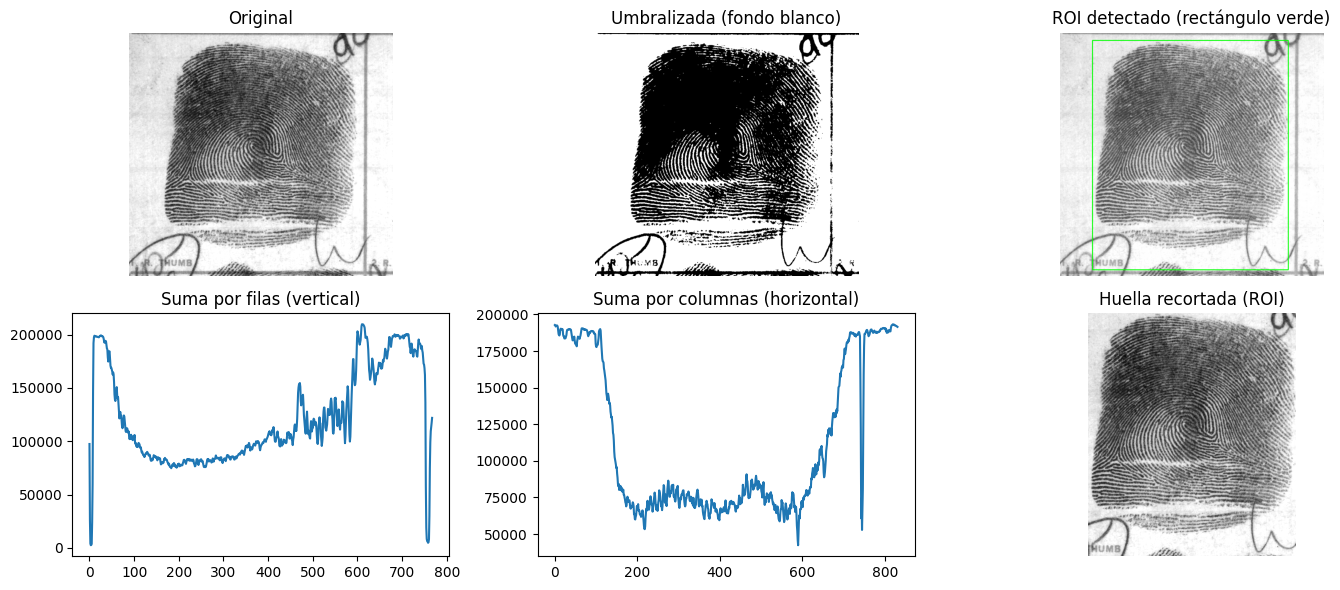

: 

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def recorte_adaptativo(img):
    if len(img.shape) == 3:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Umbralización (Otsu)
    _, thresh = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    # Asegurar fondo blanco (huella negra)
    white_ratio = np.sum(thresh == 255) / thresh.size
    black_ratio = np.sum(thresh == 0) / thresh.size
    if black_ratio > white_ratio:
        thresh = cv.bitwise_not(thresh)

    #  Detectar contornos para encontrar el ROI 
    # Invertimos: huella blanca sobre fondo negro
    inverted = cv.bitwise_not(thresh)

    # Encontrar contornos externos
    contours, _ = cv.findContours(inverted, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        print("No se detectaron contornos.")
        return img, thresh

    # Tomar el contorno más grande (la huella)
    largest_contour = max(contours, key=cv.contourArea)
    x, y, w, h = cv.boundingRect(largest_contour)

    # Margen opcional para no cortar tan justo
    margen = 10
    y1 = max(y - margen, 0)
    y2 = min(y + h + margen, img.shape[0])
    x1 = max(x - margen, 0)
    x2 = min(x + w + margen, img.shape[1])

    cropped = img[y1:y2, x1:x2]

    # También devolvemos el rectángulo y las sumas (opcional)
    sum_rows = np.sum(thresh, axis=1)
    sum_cols = np.sum(thresh, axis=0)

    return cropped, thresh, sum_rows, sum_cols, (x1, y1, x2, y2)


#  DEMO 
ruta = "../BaseDatosNISTsd09_pr/crd_0811f/crd_0811f_01.png"
img = cv.imread(ruta, cv.IMREAD_GRAYSCALE)

recortada, umbralizada, sum_rows, sum_cols, bbox = recorte_adaptativo(img)

# Dibujar el rectángulo en la imagen original
img_color = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
x1, y1, x2, y2 = bbox
cv.rectangle(img_color, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Mostrar imágenes y gráficos
plt.figure(figsize=(14, 6))

plt.subplot(2, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis("off")

plt.subplot(2, 3, 2)
plt.imshow(umbralizada, cmap='gray')
plt.title("Umbralizada (fondo blanco)")
plt.axis("off")

plt.subplot(2, 3, 3)
plt.imshow(cv.cvtColor(img_color, cv.COLOR_BGR2RGB))
plt.title("ROI detectado (rectángulo verde)")
plt.axis("off")

plt.subplot(2, 3, 4)
plt.plot(sum_rows)
plt.title("Suma por filas (vertical)")

plt.subplot(2, 3, 5)
plt.plot(sum_cols)
plt.title("Suma por columnas (horizontal)")

plt.subplot(2, 3, 6)
plt.imshow(recortada, cmap='gray')
plt.title("Huella recortada (ROI)")
plt.axis("off")

plt.tight_layout()
plt.show()

